### カラー画像を10のカテゴリに分類したCIFAR-10データセット

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


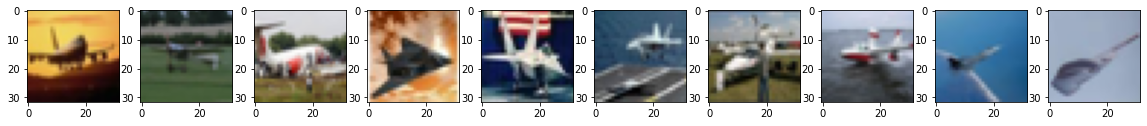

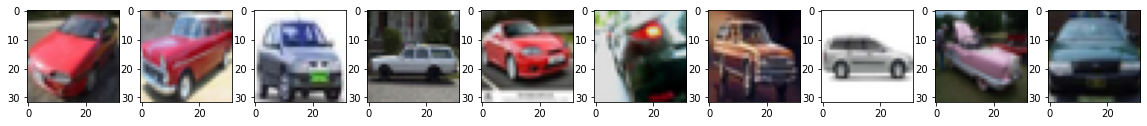

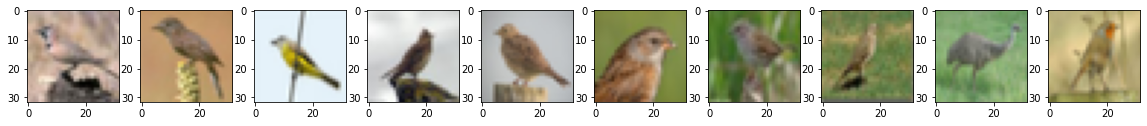

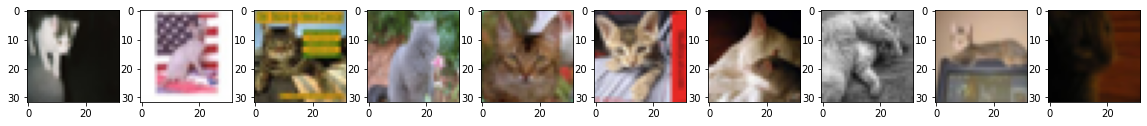

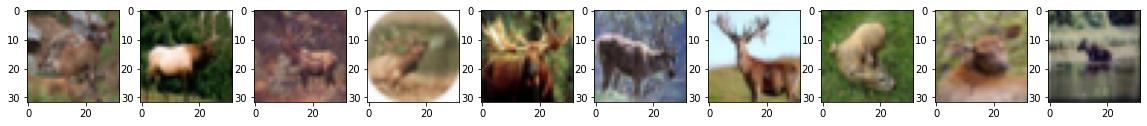

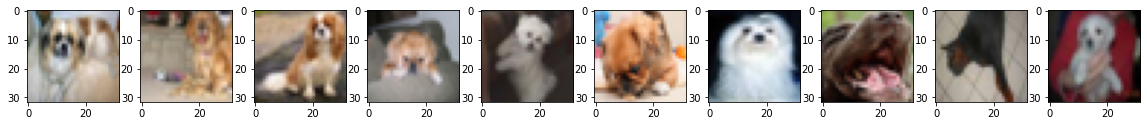

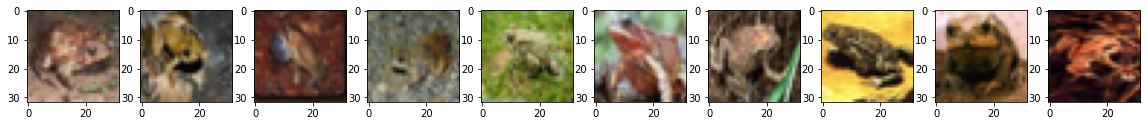

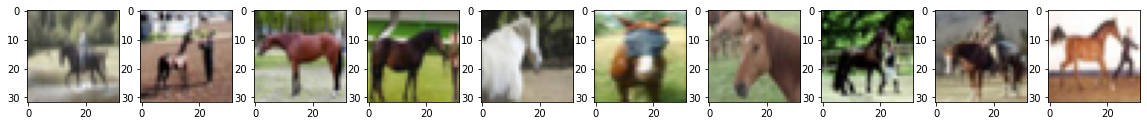

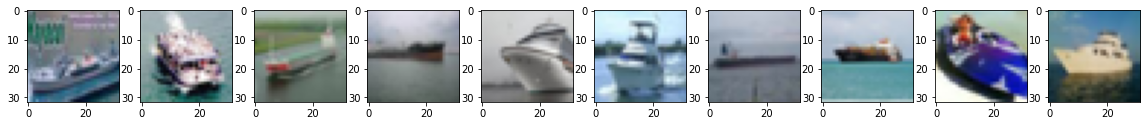

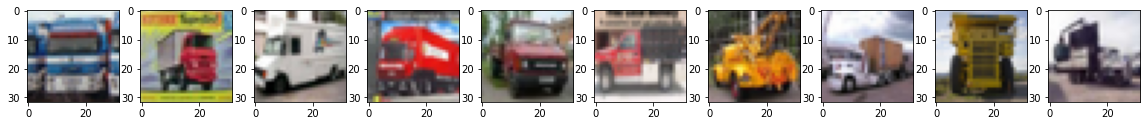

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# CIFAR-10データセットをロード
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#　データ形状を出力
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape, 'y_test:', y_test.shape)

# 画像を描画
num_classes = 10
pos = 1

# クラスの数だけ繰り返す
for target_class in range(num_classes):
    # 各クラスに分類される画像のインデックスを保持するリスト
    target_idx = []

    # クラスiが正解の場合の正解ラベルのインデックスを取得する
    for i in range(len(y_train)):
        # i行, 0列の正解ラベルがtarget_classと一致するか
        if y_train[i][0] == target_class:
            # クラスiが正解であれば正解ラベルのインデックスをtargetidxに追加
            target_idx.append(i)
    
    np.random.shuffle(target_idx)
    plt.figure(figsize=(20, 20))

    # シャッフルした最初の10枚の画像を描画
    for idx in target_idx[:10]:
        plt.subplot(10, 10, pos)
        plt.imshow(x_train[idx])
        pos += 1

plt.show()

### TenforFlowスタイルでプログラミングしたCNNに飛行機、自動車、イヌ、ネコなどの10種類の画像を認識させてみる

In [3]:
'''
1. データセットの読み込みと前処理
'''
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 訓練用とテスト用の画像データを正規化する
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train / 255, x_test / 255

# 訓練データとテストデータの正解ラベルを10クラスのOne-Hot表現に変換
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [25]:
'''
2. モデルの定義
'''
import tensorflow as tf

class CNN(tf.keras.Model):
    '''
    畳み込みニューラルネットワーク
    Attributes:
        conv2D_1(Conv2D):　畳み込み層
        conv2D_2(Conv2D):　畳み込み層
        pool1(MaxPooling2D):　プーリング層
        dropput1(Dropout):　ドロップアウト
        conv2D_3(Conv2D):　畳み込み層
        conv2D_4(Conv2D):　畳み込み層
        pool2(MaxPooling2D):　プーリング層
        dropput2(Dropout):　ドロップアウト
        flatten(Flatten):　フラット化
        fc1(Dense): 全結合層
        dropput3(Dropout):　ドロップアウト
        fc2(Dense): 全結合層
    '''
    def __init__(self):
        super().__init__()
        # 畳み込み層1：活性化関数はRelu
        self.conv2D_1 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(32, 32, 3),
            activation='relu'
        )
        # 畳み込み層2：活性化関数はRelu
        self.conv2D_2 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        )
        # プーリング層1
        self.pool1 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2)
        )
        # ドロップアウト1
        self.dropput1 = tf.keras.layers.Dropout(0.5)

        # 畳み込み層3：活性化関数はRelu
        self.conv2D_3 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        )
        # 畳み込み層4：活性化関数はRelu
        self.conv2D_4 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        )
        # プーリング層2
        self.pool2 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2)
        )
        # ドロップアウト2
        self.dropput2 = tf.keras.layers.Dropout(0.5)

        # Flatten: (28, 28, 64)の出力を(50176),にフラット化
        self.flatten = tf.keras.layers.Flatten()
        # 全結合層：活性化関数はRelu
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        # ドロップアウト3
        self.dropput3 = tf.keras.layers.Dropout(0.5)

        # 出力層：活性化関数はソフトマックス
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')
    
    @tf.function
    def call(self, x, training=None):
        '''
        CNNのインスタンスからコールバックされる関数
        Parameters:
            x(ndarray(float32)): 訓練データ、または検証データ
        Returns(float32): CNNの出力として要素数3の1階テンソル
        '''
        x = self.conv2D_1(x)
        x = self.pool1(self.conv2D_2(x))
        if training:
            x = self.dropput1(x)
        x = self.conv2D_3(x)
        x = self.pool2(self.conv2D_4(x))
        if training:
            x = self.dropput2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        if training:
            x = self.dropput3(x)
        x = self.fc2(x)
        return x

In [26]:
'''
3. 損失関数とオプティマイザーの生成
'''
# マルチクラス分類のクロスエントロピー誤差を求めるオブジェクト
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [27]:
'''
4. 勾配降下アルゴリズムによるパラメーターの更新処理を行うtrain_step()関数
'''
# 損失を記録するオブジェクトを生成
train_loss = tf.keras.metrics.Mean()
# カテゴリカルデータの精度を記録するオブジェクトを生成
train_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(x, t):
    '''
    学習を1回行う
    Parameters:
        x(ndarray(float32)): 訓練データ
        t(ndarray(float32)): 正解ラベル
    Returns:
        ステップごとのクロスエントロピー誤差
    '''
    # 自動微分による勾配計算を記録するブロック
    with tf.GradientTape() as tape:
        # 訓練データをTrueに指定し
        # モデルに入力して順伝播の出力値を取得
        outputs = model(x, training=True)
        # 出力値と正解ラベルの誤差
        tmp_loss = loss_fn(t, outputs)
    
    # tapeに記録された操作を使用して誤差の勾配を計算
    grads = tape.gradient(
        # 現在のステップの誤差
        tmp_loss,
        # バイアス、重みのリストを取得
        model.trainable_variables
    )
    # 勾配降下法の更新式を適用してバイアス、重みを更新
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 損失をMeanオブジェクトに記録
    train_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    train_accuracy(t, outputs)

In [28]:
'''
5. 検証を行うvalid_step()関数
'''
# 損失を記録するオブジェクトを生成
val_loss = tf.keras.metrics.Mean()
# カテゴリカルデータの精度を記録するオブジェクトを生成
val_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def valid_step(val_x, val_y):
    # 訓練データをFalseに指定し
    # モデルに入力して順伝播の出力値を取得
    pred = model(val_x, training=False)
    # 出力値と正解ラベルの誤差
    tmp_loss = loss_fn(val_y, pred)
    # 損失をMeanオブジェクトに記録
    val_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    val_accuracy(val_y, pred)

In [29]:
'''
6. 学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=1.0, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数
            verbose(int): 早期終了メッセージの出力フラグ
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメータで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメータで初期化
        self.verbose = verbose
    
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Returns:
            True: 監視回数の上限までに前エポックの損失を超えた場合
            False: 監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            # カウンターを1増やす
            self.epoch += 1
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                # 早期終了メッセージの出力フラグが1の場合
                if self.verbose:
                    # メッセージを出力
                    print('early stopping')
                # 学習を終了するTrueを返す
                return True
        # 前エポックの損失以下の場合
        else:
            # カウンターを0に戻す
            self.epoch = 0
            # 損失の値を更新する
            self.pre_loss = current_loss
        
        # 監視回数の上限までに前エポックの損失を超えなければFalseを返して
        # 前エポックの損失を上回るが監視関数の範囲内であれば
        # Falseを返す必要があるので、return文の位置をここであることに注意
        return False

In [30]:
'''
7. 訓練データと検証データの用意
'''
from sklearn.model_selection import train_test_split

# 訓練データと検証データに8:2の割合で分割
tr_x, val_x, tr_y, val_y = train_test_split(x_train, y_train, test_size=0.2)
print(tr_x.shape)
print(val_x.shape)
print(tr_y.shape)
print(val_y.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


In [ ]:
'''
8. モデルを生成して学習する
'''
from sklearn.utils import shuffle

# エポック数
epochs = 200
# ミニバッチのサイズ
batch_size = 64
# 訓練データのステップ数
tr_steps = tr_x.shape[0] // batch_size
# 検証データのステップ数
val_steps = val_x.shape[0] // batch_size

# 隠れ層256ユニット、出力層10ユニットのモデルを生成
model = CNN()
# 損失と精度の履歴を保存するためにdictオブジェクト
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=20, verbose=1)

# 学習を行う
for epoch in range(epochs):
    # 学習するたびに記録された値をリセット
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # 訓練データと正解ラベルをシャッフル
    x_, y_ = shuffle(tr_x, tr_y, )

    # 1ステップにおける訓練用ミニバッチを使用した学習
    for step in range(tr_steps):
        start = step * batch_size
        end = start + batch_size
        # ミニバッチでバイアス、重みを更新して誤差を取得
        train_step(x_[start:end], y_[start:end])
    
    # 1ステップにおける検証用ミニバッチを使用した評価
    for step in range(val_steps):
        start = step * batch_size
        end = start + batch_size
        # ミニバッチでバイアス、重みを更新して誤差を取得
        valid_step(val_x[start:end], val_y[start:end])
    
    avg_train_loss = train_loss.result()
    avg_train_acc = train_accuracy.result()
    avg_val_loss = val_loss.result()
    avg_val_acc = val_accuracy.result()

    # 損失を履歴を保存する
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    # 精度を履歴を保存する
    history['accuracy'].append(avg_train_acc)
    history['val_accuracy'].append(avg_val_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc {:.4} val_loss {:.4} val_acc {:.4}'
            .format(
                epoch + 1,
                avg_train_loss,
                avg_train_acc,
                avg_val_loss,
                avg_val_acc,
            )
        )

    # 検証データの損失をEarlyStoppingオブジェクトに達して早期終了を判定
    if ers(val_loss.result()):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break
model.summary()

epoch(1) train_loss: 2.31 train_acc 0.1072 val_loss 2.299 val_acc 0.1073
epoch(2) train_loss: 2.299 train_acc 0.1157 val_loss 2.295 val_acc 0.1274
epoch(3) train_loss: 2.292 train_acc 0.1204 val_loss 2.289 val_acc 0.141
epoch(4) train_loss: 2.284 train_acc 0.1316 val_loss 2.278 val_acc 0.1513
epoch(5) train_loss: 2.269 train_acc 0.1411 val_loss 2.259 val_acc 0.1749
epoch(6) train_loss: 2.243 train_acc 0.1586 val_loss 2.226 val_acc 0.203
epoch(7) train_loss: 2.208 train_acc 0.1791 val_loss 2.181 val_acc 0.2319
epoch(8) train_loss: 2.169 train_acc 0.1959 val_loss 2.131 val_acc 0.2485
epoch(9) train_loss: 2.127 train_acc 0.2132 val_loss 2.083 val_acc 0.2532
epoch(10) train_loss: 2.094 train_acc 0.224 val_loss 2.052 val_acc 0.2601
epoch(11) train_loss: 2.074 train_acc 0.2312 val_loss 2.032 val_acc 0.2652
epoch(12) train_loss: 2.058 train_acc 0.2361 val_loss 2.017 val_acc 0.271
epoch(13) train_loss: 2.047 train_acc 0.2418 val_loss 2.006 val_acc 0.2732


In [ ]:
'''
9. 損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

# 学習結果（損失）のグラフを描画
plt.plot(
    history['loss'],
    marker='.',
    label='loss (Training)'
)
plt.plot(
    history['val_loss'],
    marker='.',
    label='loss (Validation)'
)
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 学習結果（精度）のグラフを描画
plt.plot(
    history['accuracy'],
    marker='.',
    label='accuracy (Training)'
)
plt.plot(
    history['val_accuracy'],
    marker='.',
    label='accuracy (Validation)'
)
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()